# Temporal Clusters in the rainfall data

## Given the spatial distribution of rainfall over India is it possible to tell when the data were observed?

### Step - 1: Prepare the data to feed Spectral Clustering

In [7]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler

# set random seed
np.random.seed(seed = 4200)

# import data
rain = np.load("../../data/rainfall/Rajeevan-1-degree-1901-2011-data-365-days.npy")

# pick a random year from the dataset
random_year = np.random.randint(111)
rain_ry = rain[random_year]
idx=np.where(rain_ry<0.01)
rain_ry[idx]=0.001


# create a function to compute running mean
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# compute the num_day running average
num_days = 3
n = rain_ry.shape[1] - num_days + 1
rain_ry_avg = np.zeros((rain_ry.shape[0],n ))
for loc in range(rain_ry.shape[0]):
    rain_ry_avg[loc] = running_mean(rain_ry[loc,:], num_days) 

#rain_ry_avg=np.log(rain_ry_avg)  <-- log experiment

# scale the data in a standard way
scaler = StandardScaler()
scaler.fit(rain_ry_avg.T)
scaled_rain=scaler.transform(rain_ry_avg.T)
#plt.plot(scaled_rain,'.')

### Step - 2: Apply Spectral and k-means clustering for k = 2,3,4,5

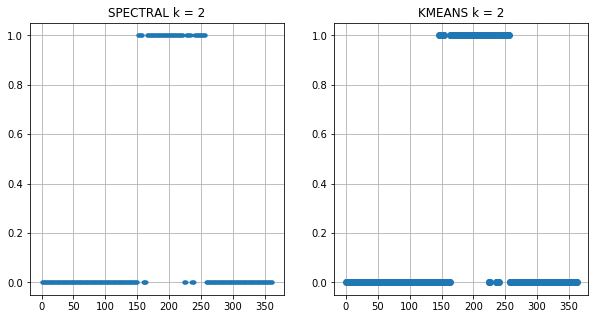

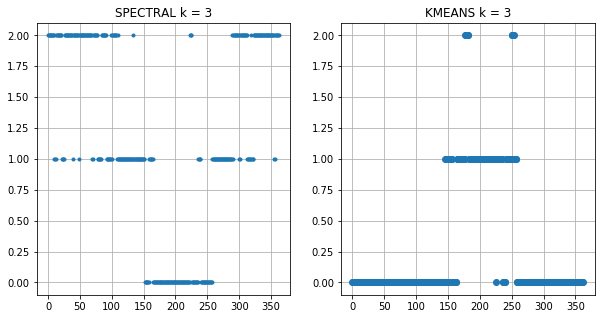

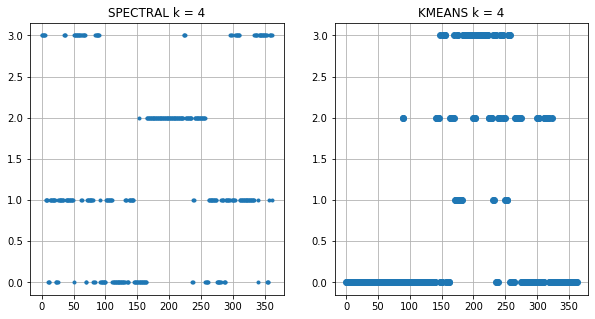

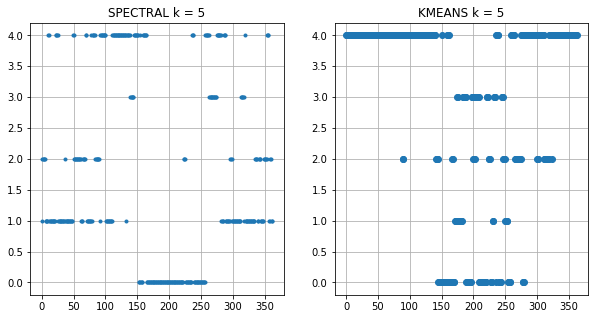

In [8]:
from sklearn.cluster import SpectralClustering, DBSCAN, KMeans
from scipy.spatial.distance import cdist 
clusters_S = []
clusters_K = []
distortions=[]
inertias=[]
kmax=5
#clusters = DBSCAN(eps = 10, min_samples = 20).fit(scaled_rain)
for k in range(2, kmax+1):
    clusters_S.append(SpectralClustering(n_clusters = k,random_state=0,n_init=3,affinity='nearest_neighbors').fit(scaled_rain))
    clusters_K.append(KMeans(n_clusters=k,init='k-means++',max_iter=1000,n_init=3,random_state=0).fit(scaled_rain))
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(clusters_S[k-2].labels_,'.')
    plt.title('SPECTRAL k = '+ str(k))
    plt.grid()
    plt.subplot(122)
    plt.plot(clusters_K[k-2].labels_,'o')
    plt.grid()
    plt.title('KMEANS k = '+ str(k))
    
    distortions.append(sum(np.min(cdist(scaled_rain, clusters_K[k-2].cluster_centers_, 
                      'euclidean'),axis=1)) / scaled_rain.shape[0]) 
    inertias.append(clusters_K[k-2].inertia_) 

### Step - 3: Apply elbow method and compute silhouette scores to explore the optimal number of clusters

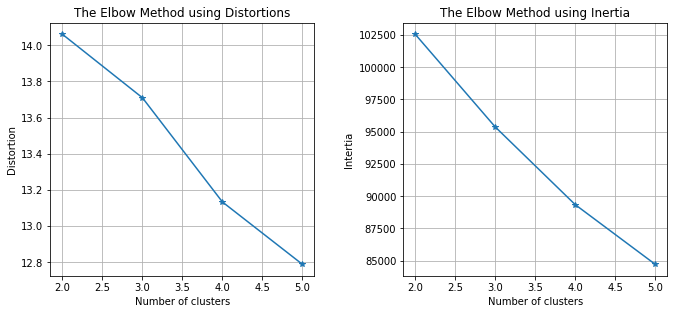

In [19]:
# elbow method for finding optimal number of clusters
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.arange(2,kmax+1,1),distortions,'*-')
plt.title('The Elbow Method using Distortions')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.grid()

plt.subplot(122)
plt.plot(np.arange(2,kmax+1,1),inertias,'*-')
plt.title('The Elbow Method using Inertia') 
plt.xlabel('Number of clusters')
plt.ylabel('Intertia')
plt.grid()

plt.tight_layout(pad = 3.0)

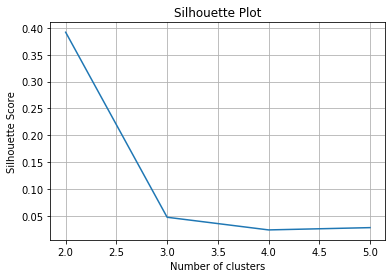

In [17]:
# silhouette score method for finding the optimal number of clusters
from sklearn.metrics import silhouette_score
ss = np.zeros(kmax + 1 - 2)
for k in range(2, kmax+1):
    ss[k-2] = silhouette_score(scaled_rain, clusters_S[k-2].fit_predict(scaled_rain))

plt.plot(range(2, kmax+1), ss)
plt.title('Silhouette Plot')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid()

####  The elbow method is not useful here, a sharp elbow can't be found even when kmax = 30. The optimal number of clusters is most likely 2.

### Step - 4: Can we tell if a certain day belonged to the monsoon period?

#### Since June - September is the typical monsoon period in India and corresspoding days are 150-270, k=2 clearly shows a distinction between monsoon and non-monsoon days. Assuming days 150-270 are the monsoon days we count the number of misclassifications below.

In [60]:
# count the number of misclassifications for k = 2
m_start, m_end = 150, 270
labels = clusters_S[0].fit_predict(scaled_rain)
m_cl_as_nm = len(labels[m_start: m_end]) - np.count_nonzero(labels[m_start: m_end])
nm_cl_as_m = np.count_nonzero(labels[: m_start]) + np.count_nonzero(labels[m_end :])
mis_cl = nm_cl_as_m + m_cl_as_nm
print('Number of monsoon days classified as non-monsoon = {}'.format(m_cl_as_nm))
print('Number of non-monsoon days classified as monsoon = {}'.format(nm_cl_as_m))
print('Number of total misclassification = {}'.format(mis_cl))
print('Accuracy score = {}'.format((len(labels) - mis_cl)/len(labels)))

Number of monsoon days classified as non-monsoon = 28
Number of non-monsoon days classified as monsoon = 0
Number of total misclassification = 28
Accuracy score = 0.9228650137741047
